In [2]:
# pip install openpyxl instalar esto
import rdata
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

import statsmodels.tsa as tsa
import statsmodels as sm
from datetime import datetime
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from scipy.stats import shapiro

In [54]:
hoja_df = pd.read_excel("./data/CONSUMO-HIDROCARBUROS-2024-12.xlsx", header=6)

hoja_df = hoja_df.iloc[:-3]

hoja_df["Fecha"] = pd.to_datetime(hoja_df["Fecha"])
hoja_df["Año"] = hoja_df["Fecha"].dt.year
hoja_df["Mes"] = hoja_df["Fecha"].dt.month

# Crear conjunto de test con años 2023 y 2024
test_2023_2024 = hoja_df[hoja_df["Año"].isin([2023, 2024])][["Fecha", "Gasolina superior"]]


In [55]:
train_data = hoja_df[hoja_df["Año"] < 2023][["Fecha", "Gasolina superior"]] # [hoja_df["Año"] < 2025]
train_data["Fecha"] = pd.to_datetime(train_data["Fecha"])
train_data["Año"] = train_data["Fecha"].dt.year
train_data["Mes"] = train_data["Fecha"].dt.month
train_data = train_data[~train_data["Año"].isin([2023, 2024, 2025])]
train_data


,Fecha,Gasolina superior,Año,Mes
0,2000-01-01,308156.82,2000,1
1,2000-02-01,307766.31,2000,2
2,2000-03-01,331910.29,2000,3
3,2000-04-01,315648.08,2000,4
4,2000-05-01,319667.97,2000,5
...,...,...,...,...
271,2022-08-01,581844.42,2022,8
272,2022-09-01,570632.20,2022,9
273,2022-10-01,573943.48,2022,10
274,2022-11-01,572163.23,2022,11


In [56]:
train_data = train_data.copy()
train_data["Fecha"] = pd.to_datetime(train_data["Fecha"])
train_data.set_index("Fecha", inplace=True)

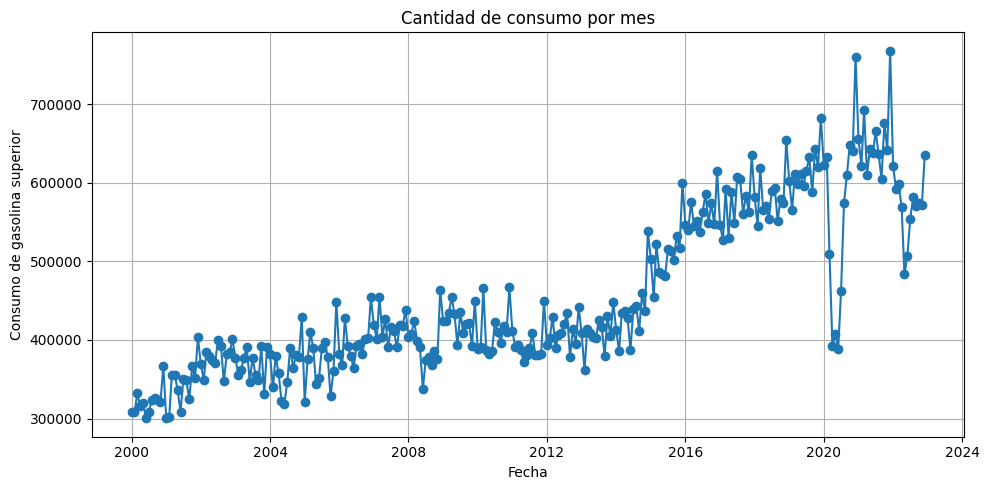

In [57]:
import matplotlib.pyplot as plt

# Graficar solo la columna de consumo
plt.figure(figsize=(10, 5))
plt.plot(train_data["Gasolina superior"], marker='o')

plt.title("Cantidad de consumo por mes")
plt.xlabel("Fecha")
plt.ylabel("Consumo de gasolina superior")
plt.grid(True)
plt.tight_layout()
plt.show()


# Insertar aqui una explicacion

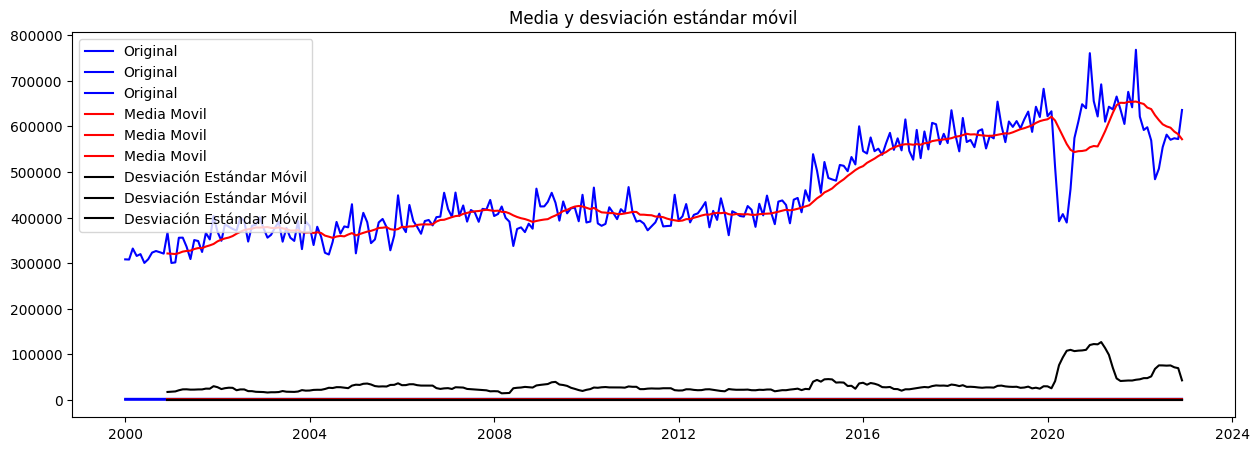

In [58]:
# Se calcula la media móvil y la desviación estandar móvil de los últimos 12 meses.
mediaMovil = train_data.rolling(window=12).mean()
deMovil = train_data.rolling(window=12).std()
# Se grafican los resultados.
original = plt.plot(train_data, color="blue", label="Original")
media = plt.plot(mediaMovil, color='red', label = 'Media Movil')
ds = plt.plot(deMovil,color='black', label = 'Desviación Estándar Móvil')
plt.legend(loc = 'best')
plt.title('Media y desviación estándar móvil')
plt.show(block=False)

# Insertar texto aqui

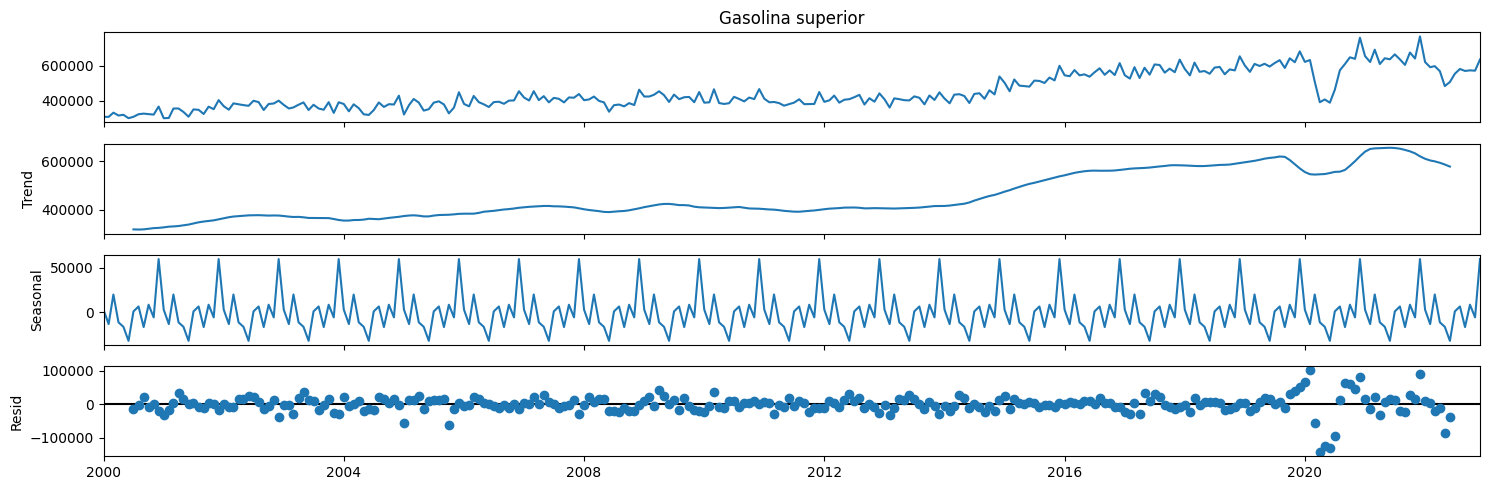

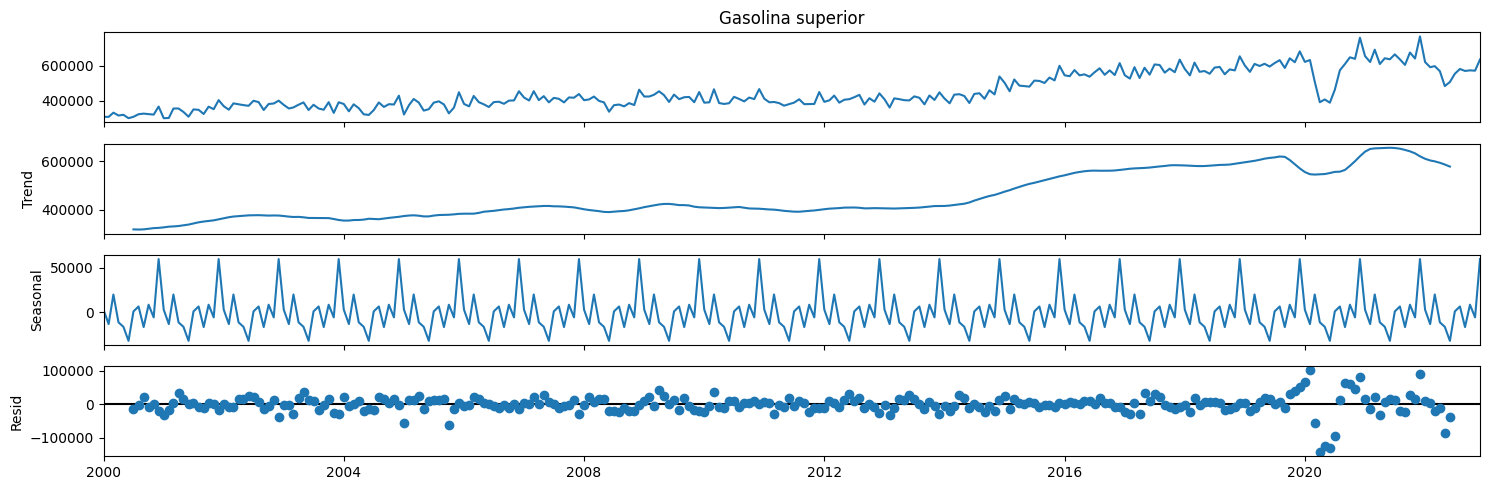

In [59]:
descomposicion = seasonal_decompose(train_data["Gasolina superior"])
descomposicion.plot()

No estacionaria en media
No estacionaria en varianza
# Insertar explicaciona aqui

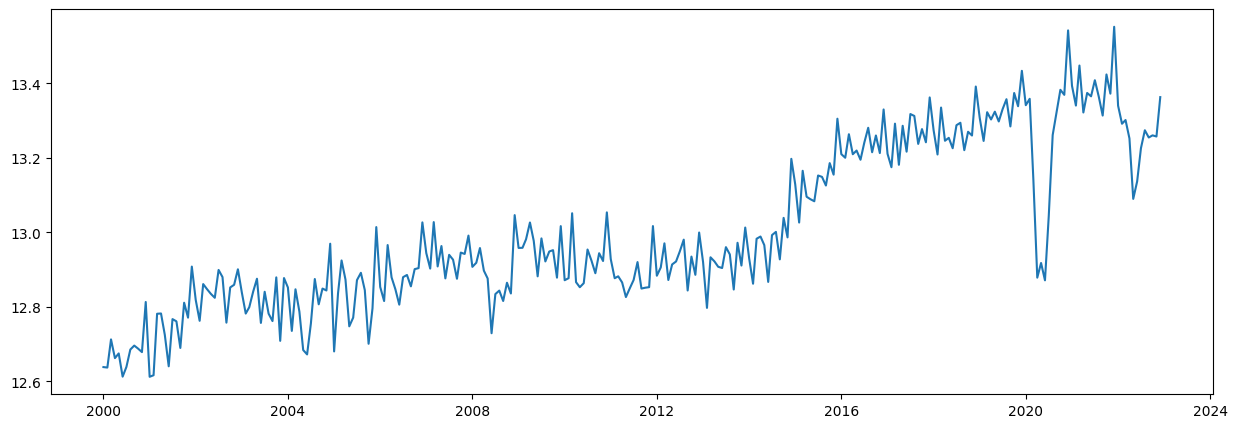

In [60]:
ts_air_pas_log = np.log(train_data["Gasolina superior"])
plt.plot(ts_air_pas_log)

In [61]:
print('Resultados del Test de Dickey Fuller')
dfTest = adfuller(train_data["Gasolina superior"], autolag='AIC')
salidaDf = pd.Series(dfTest[0:4], index=['Estadístico de prueba','p-value','# de retardos usados','# de observaciones usadas'])
for key,value in dfTest[4].items():
        salidaDf['Critical Value (%s)'%key] = value
print(salidaDf)

Resultados del Test de Dickey Fuller
Estadístico de prueba         -1.268840
p-value                        0.643305
# de retardos usados          12.000000
# de observaciones usadas    263.000000
Critical Value (1%)           -3.455461
Critical Value (5%)           -2.872593
Critical Value (10%)          -2.572660
dtype: float64


El p-value es mayor a 0.05 por lo que no se puede rechazar la hipótesis nula de que existen raices unitarias. La serie no es estacionaria en media. Vamos a probar con una diferenciación

In [62]:
print('Resultados del Test de Dickey Fuller para una diferenciación de la serie')
ts_air_pas_diff = train_data["Gasolina superior"].diff()
ts_air_pas_diff.dropna(inplace=True)
dfTest = adfuller(ts_air_pas_diff)
salidaDf = pd.Series(dfTest[0:4], index=['Estadístico de prueba','p-value','# de retardos usados','# de observaciones usadas'])
for key,value in dfTest[4].items():
        salidaDf['Critical Value (%s)'%key] = value
print(salidaDf)

Resultados del Test de Dickey Fuller para una diferenciación de la serie
Estadístico de prueba       -5.787650e+00
p-value                      4.956215e-07
# de retardos usados         1.100000e+01
# de observaciones usadas    2.630000e+02
Critical Value (1%)         -3.455461e+00
Critical Value (5%)         -2.872593e+00
Critical Value (10%)        -2.572660e+00
dtype: float64


 Esto significa que rechazamos la hipótesis nula ⇒ la serie diferenciada es estacionaria en media.

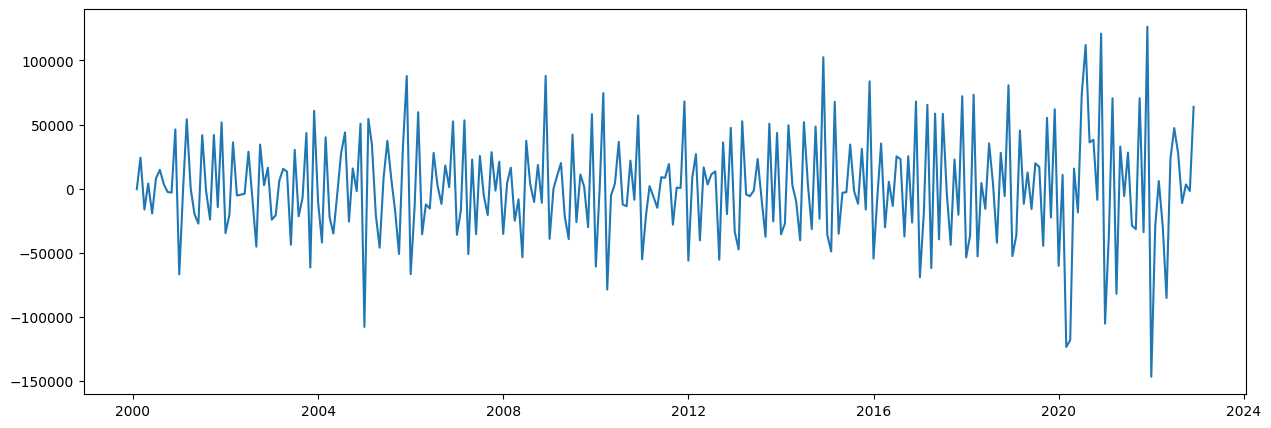

In [63]:
plt.plot(ts_air_pas_diff)

# Insertar aqio algo

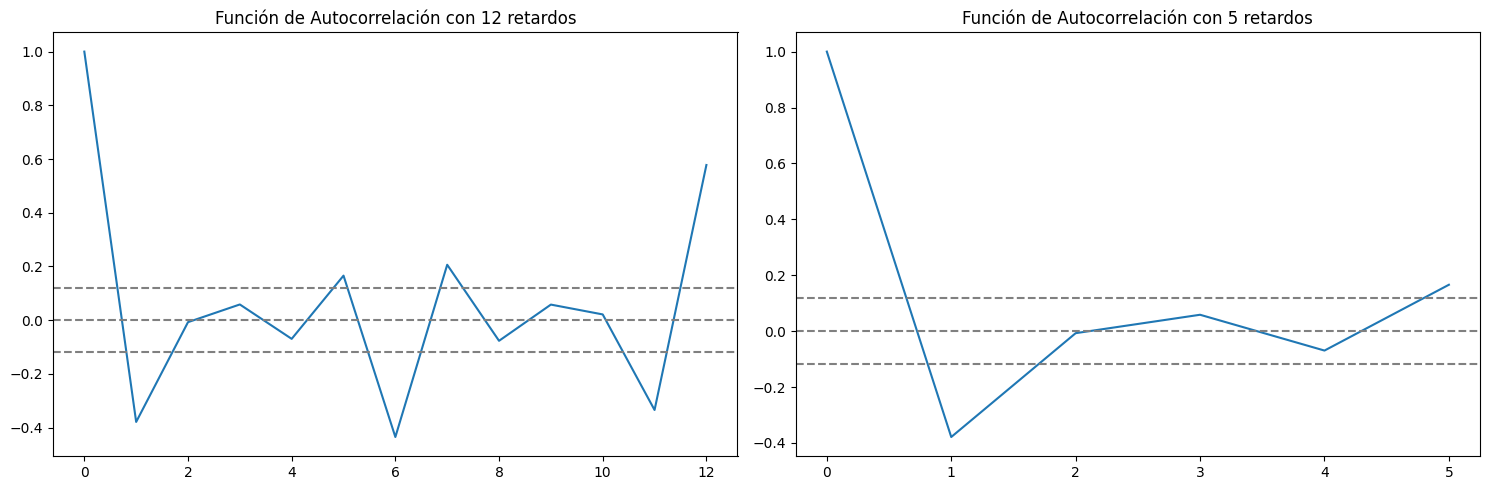

In [64]:

plt.rcParams['figure.figsize'] = [15, 5]
plt.rcParams['figure.dpi'] = 100 # 200 e.g. is really fine, but slower

#Plot ACF: 
plt.subplot(121) 
plt.plot(acf(ts_air_pas_diff,nlags=12,fft=False))
plt.axhline(y=0,linestyle='--',color='gray')
plt.axhline(y=-1.96/np.sqrt(len(ts_air_pas_diff)),linestyle='--',color='gray')
plt.axhline(y=1.96/np.sqrt(len(ts_air_pas_diff)),linestyle='--',color='gray')
plt.title('Función de Autocorrelación con 12 retardos')

plt.subplot(122) 
plt.plot(acf(ts_air_pas_diff,nlags=5,fft=False))
plt.axhline(y=0,linestyle='--',color='gray')
plt.axhline(y=-1.96/np.sqrt(len(ts_air_pas_diff)),linestyle='--',color='gray')
plt.axhline(y=1.96/np.sqrt(len(ts_air_pas_diff)),linestyle='--',color='gray')
plt.title('Función de Autocorrelación con 5 retardos')

plt.tight_layout()

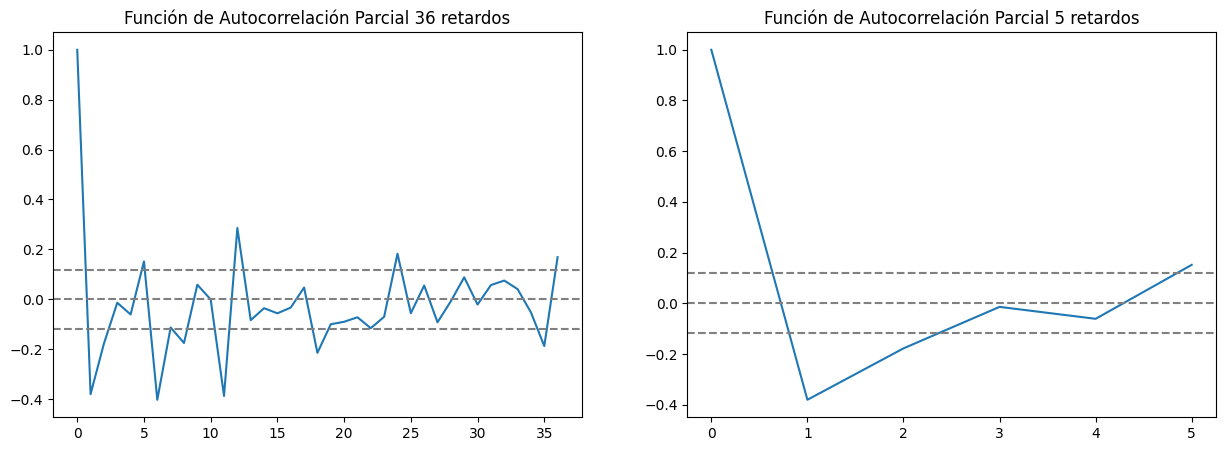

In [65]:
#plot PACF
plt.subplot(121)
plt.plot(pacf(ts_air_pas_diff, nlags=36))
plt.axhline(y=0,linestyle='--',color='gray')
plt.axhline(y=-1.96/np.sqrt(len(ts_air_pas_diff)),linestyle='--',color='gray')
plt.axhline(y=1.96/np.sqrt(len(ts_air_pas_diff)),linestyle='--',color='gray')
plt.title('Función de Autocorrelación Parcial 36 retardos')

plt.subplot(122)
plt.plot(pacf(ts_air_pas_diff, nlags=5))
plt.axhline(y=0,linestyle='--',color='gray')
plt.axhline(y=-1.96/np.sqrt(len(ts_air_pas_diff)),linestyle='--',color='gray')
plt.axhline(y=1.96/np.sqrt(len(ts_air_pas_diff)),linestyle='--',color='gray')
plt.title('Función de Autocorrelación Parcial 5 retardos')

plt.rcParams['figure.figsize'] = [15, 5]
plt.rcParams['figure.dpi'] = 100 # 200 e.g. is really fine, but slower

# Isnertar explicacion

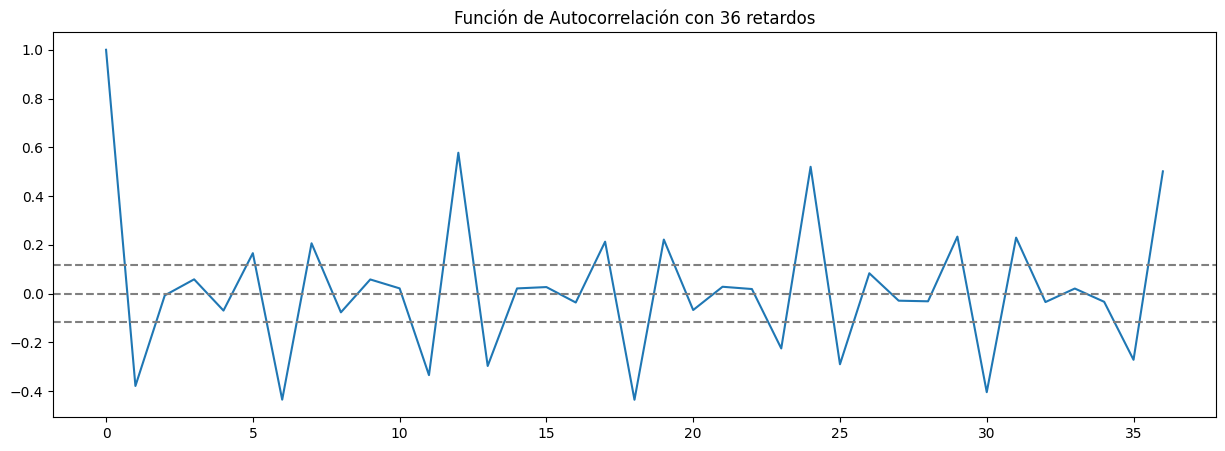

In [66]:
plt.plot(acf(ts_air_pas_diff,nlags=36,fft=False))
plt.axhline(y=0,linestyle='--',color='gray')
plt.axhline(y=-1.96/np.sqrt(len(ts_air_pas_diff)),linestyle='--',color='gray')
plt.axhline(y=1.96/np.sqrt(len(ts_air_pas_diff)),linestyle='--',color='gray')
plt.title('Función de Autocorrelación con 36 retardos')
plt.rcParams['figure.figsize'] = [15, 5]
plt.rcParams['figure.dpi'] = 100 # 200 e.g. is really fine, but slower

In [67]:
ts_air_pas_diff_D = ts_air_pas_diff.diff(12)
ts_air_pas_diff_D.dropna(inplace=True)

Text(0.5, 1.0, 'Función de Autocorrelación Parcial 5 retardos')

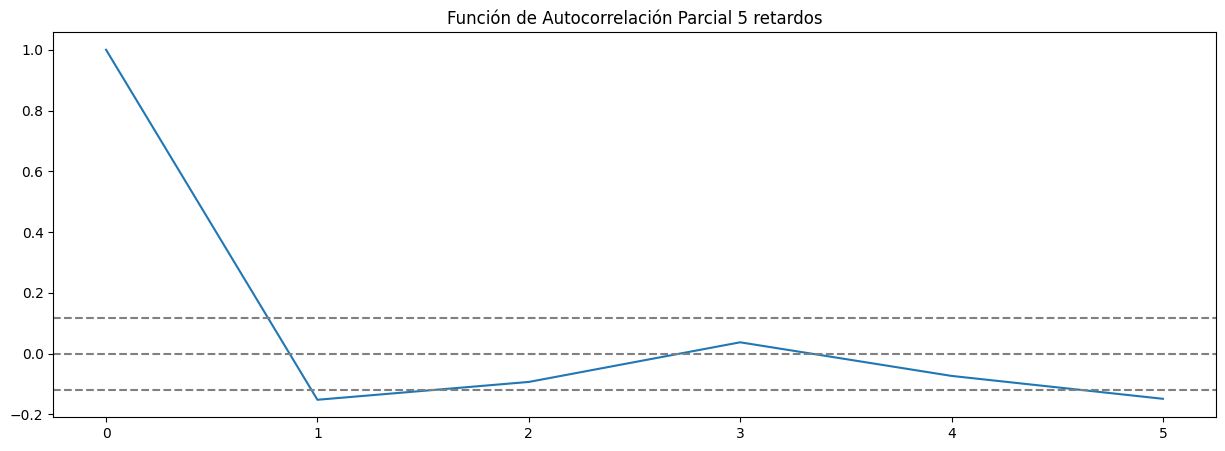

In [68]:
plt.plot(pacf(ts_air_pas_diff_D, nlags=5))
plt.axhline(y=0,linestyle='--',color='gray')
plt.axhline(y=-1.96/np.sqrt(len(ts_air_pas_diff)),linestyle='--',color='gray')
plt.axhline(y=1.96/np.sqrt(len(ts_air_pas_diff)),linestyle='--',color='gray')
plt.title('Función de Autocorrelación Parcial 5 retardos')


In [69]:
modelo_sarima = SARIMAX(
    ts_air_pas_diff,
    order=(1, 1, 1),                 # ARIMA(p,d,q)
    seasonal_order=(1, 1, 1, 12),    # SARIMA(P,D,Q,s)
    enforce_stationarity=False,
    enforce_invertibility=False
)
resultado_sarima = modelo_sarima.fit()

print(resultado_sarima.summary().tables[1])

C:\Users\Gerax\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\Gerax\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.2049      0.069     -2.949      0.003      -0.341      -0.069
ma.L1         -0.9891      0.057    -17.255      0.000      -1.101      -0.877
ar.S.L12      -0.1133      0.181     -0.626      0.531      -0.468       0.241
ma.S.L12      -0.7412      0.131     -5.659      0.000      -0.998      -0.484
sigma2      1.763e+09   5.58e-11   3.16e+19      0.000    1.76e+09    1.76e+09


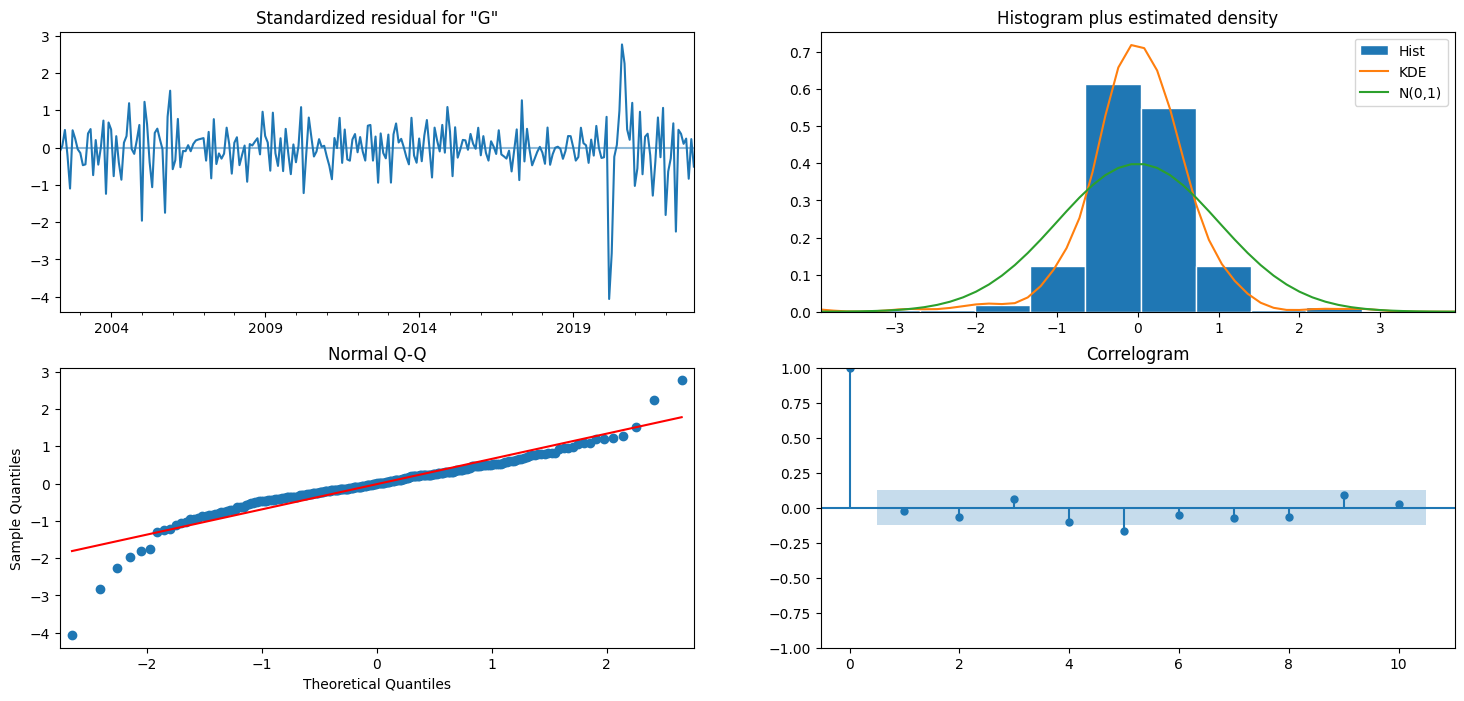

In [70]:
resultado_sarima.plot_diagnostics(figsize=(18, 8))
plt.show()

In [71]:
modelo_2 = SARIMAX(
    ts_air_pas_diff,
    order=(2, 1, 0),
    seasonal_order=(1, 1, 1, 12),
    enforce_stationarity=False,
    enforce_invertibility=False
)
resultado_2 = modelo_2.fit()
print("Modelo SARIMA(2,1,0)(1,1,1,12)")
print(resultado_2.summary().tables[1])

C:\Users\Gerax\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\Gerax\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


Modelo SARIMA(2,1,0)(1,1,1,12)
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.8276      0.063    -13.038      0.000      -0.952      -0.703
ar.L2         -0.4522      0.071     -6.369      0.000      -0.591      -0.313
ar.S.L12      -0.1324      0.133     -0.998      0.318      -0.393       0.128
ma.S.L12      -0.7418      0.086     -8.642      0.000      -0.910      -0.574
sigma2      1.801e+09   3.44e-11   5.23e+19      0.000     1.8e+09     1.8e+09


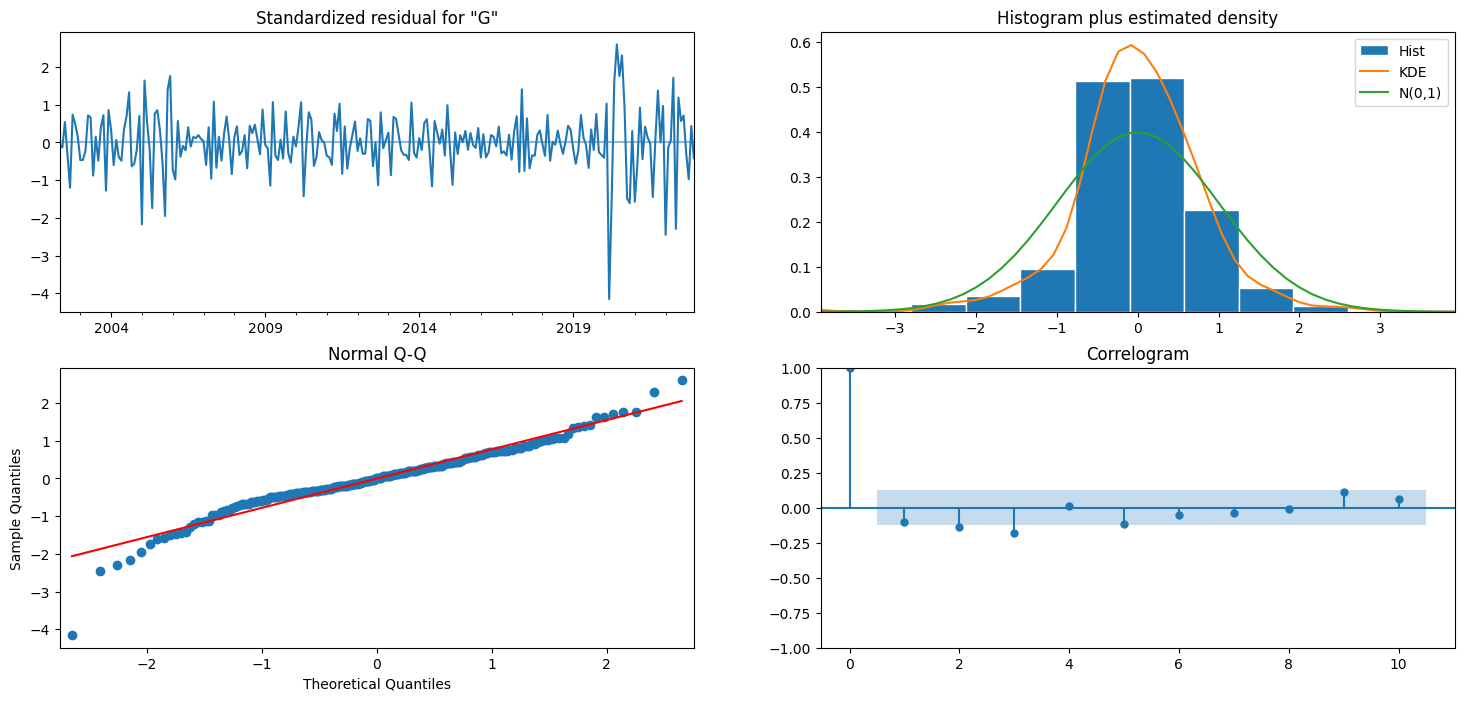

In [73]:
resultado_2.plot_diagnostics(figsize=(18, 8))
plt.show()

In [74]:
print("Resultados de AIC (Akaike information criterion)")
print("Modelo 1=",resultado_sarima.aic)
print("Modelo 2=",resultado_2.aic)
print("Resultados de BIC (Bayesian information criterion)")
print("Modelo 1=",resultado_sarima.bic)
print("Modelo 2=",resultado_2.bic)

Resultados de AIC (Akaike information criterion)
Modelo 1= 5861.609942678226
Modelo 2= 5900.663030151794
Resultados de BIC (Bayesian information criterion)
Modelo 1= 5879.17708640905
Modelo 2= 5918.230173882619


In [75]:
hoja_df_2025 = pd.read_excel("./data/VENTAS-HIDROCARBUROS-2025-05.xlsx", header=6)
hoja_df_2025 = hoja_df_2025.iloc[:-3]

hoja_df_2025["Fecha"] = pd.to_datetime(hoja_df_2025["Fecha"])
hoja_df_2025["Año"] = hoja_df_2025["Fecha"].dt.year
hoja_df_2025["Mes"] = hoja_df_2025["Fecha"].dt.month

test_2025 = hoja_df_2025[["Fecha", "Gasolina superior"]]
test_data = pd.concat([test_2023_2024, test_2025], ignore_index=True)
test_data.set_index("Fecha", inplace=True)

In [76]:
test_data.index[0]

Timestamp('2023-01-01 00:00:00')

In [77]:
# Obtener predicciones desde el modelo
pred = resultado_2.get_prediction(start=test_data.index[0], end=test_data.index[-1], dynamic=False)
pred_diff = pred.predicted_mean

# Reconstruir valores originales sumando las diferencias al último valor conocido del train
last_train_value = train_data["Gasolina superior"].iloc[-1]
predicted_real = pred_diff.cumsum() + last_train_value


In [78]:
comparison_df = pd.DataFrame({
    "Real": test_data["Gasolina superior"],
    "Predicción (SARIMA)": predicted_real
})


In [79]:
comparison_df

,Real,Predicción (SARIMA)
2023-01-01,599501.29,543719.351021
2023-02-01,544144.00,516286.131348
2023-03-01,656941.64,520007.342395
2023-04-01,586642.20,451433.859253
2023-05-01,646221.20,445509.535561
2023-06-01,616290.21,421259.152645
2023-07-01,642098.16,449677.233807
2023-08-01,632333.40,456668.168662
2023-09-01,597670.26,423370.714541
2023-10-01,531542.58,450817.557389


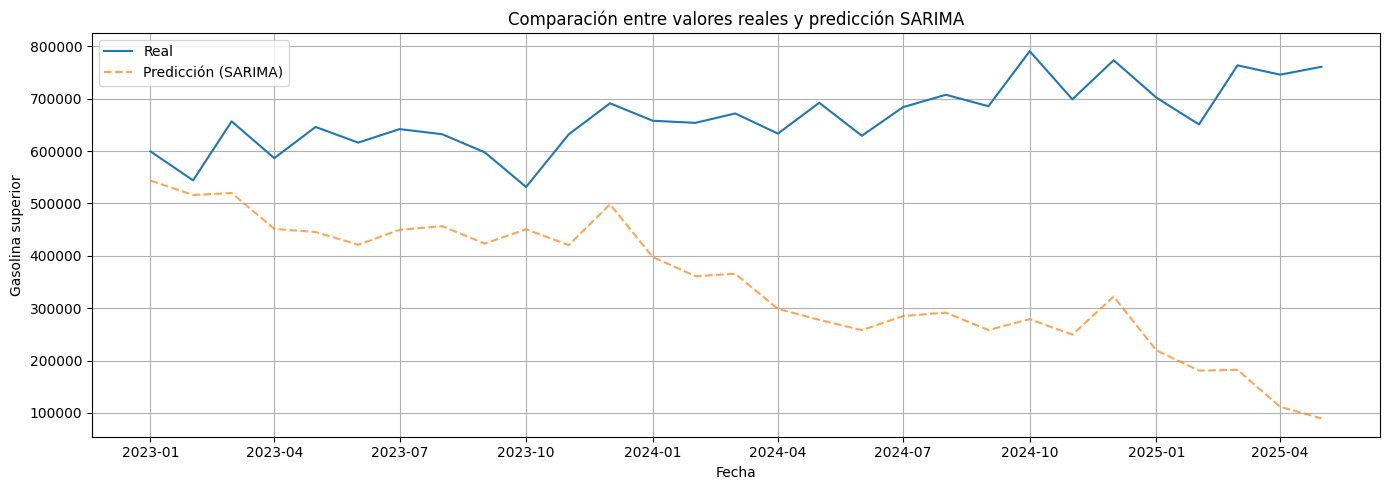

In [80]:
import matplotlib.pyplot as plt

# Asegúrate de que el índice sea tipo datetime para graficar correctamente
comparison_df.index = pd.to_datetime(comparison_df.index)

# Graficar
plt.figure(figsize=(14, 5))
plt.plot(comparison_df["Real"], label="Real")
plt.plot(comparison_df["Predicción (SARIMA)"], label="Predicción (SARIMA)", linestyle="--", alpha=0.7)
plt.title("Comparación entre valores reales y predicción SARIMA")
plt.xlabel("Fecha")
plt.ylabel("Gasolina superior")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [108]:
pred = resultado_2.get_prediction(start=test_data.index[0], end=test_data.index[-1], dynamic=False)

# Si entrenaste en la serie diferenciada y log, convierte de regreso
# Reversión de log (si usaste np.log)
predicted_values = np.exp(pred.predicted_mean)

# Ahora puedes comparar directamente
comparison_df = pd.DataFrame({
    "Real": test_data["Gasolina superior"],
    "Predicción (SARIMA)": predicted_values
})


C:\Users\Gerax\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: overflow encountered in exp
  result = getattr(ufunc, method)(*inputs, **kwargs)


In [109]:
comparison_df

,Real,Predicción (SARIMA)
2023-01-01,599501.29,0.0
2023-02-01,544144.00,0.0
2023-03-01,656941.64,inf
2023-04-01,586642.20,0.0
2023-05-01,646221.20,0.0
2023-06-01,616290.21,0.0
2023-07-01,642098.16,inf
2023-08-01,632333.40,inf
2023-09-01,597670.26,0.0
2023-10-01,531542.58,inf


In [ ]:
pred = resultado_m121.get_prediction(start=test_airPas.index[0], dynamic=False)


<Axes: xlabel='Fecha'>

In [95]:
# Obtener las predicciones en diferencias
pred = resultado_sarima.get_prediction(start=test_data.index[0], dynamic=False)
predicted_diff = pred.predicted_mean

# Recuperar valores originales a partir del último valor real del entrenamiento
last_train_value = train_data["Gasolina superior"].iloc[-1]
predicted_real = predicted_diff.cumsum() + last_train_value


In [ ]:

# Asegura que los predichos tienen el mismo índice
predicted_real.index = test_data.index

# Crear el DataFrame combinado
comparacion_df = pd.DataFrame({
    "Real": test_data["Gasolina superior"],
    "Predicción SARIMA": predicted_real
})

# Mostrar las primeras filas para revisar
print(comparacion_df.head())


ValueError: Length mismatch: Expected axis has 1 elements, new values have 29 elements

2023-01-01    561208.378998
Freq: MS, dtype: float64


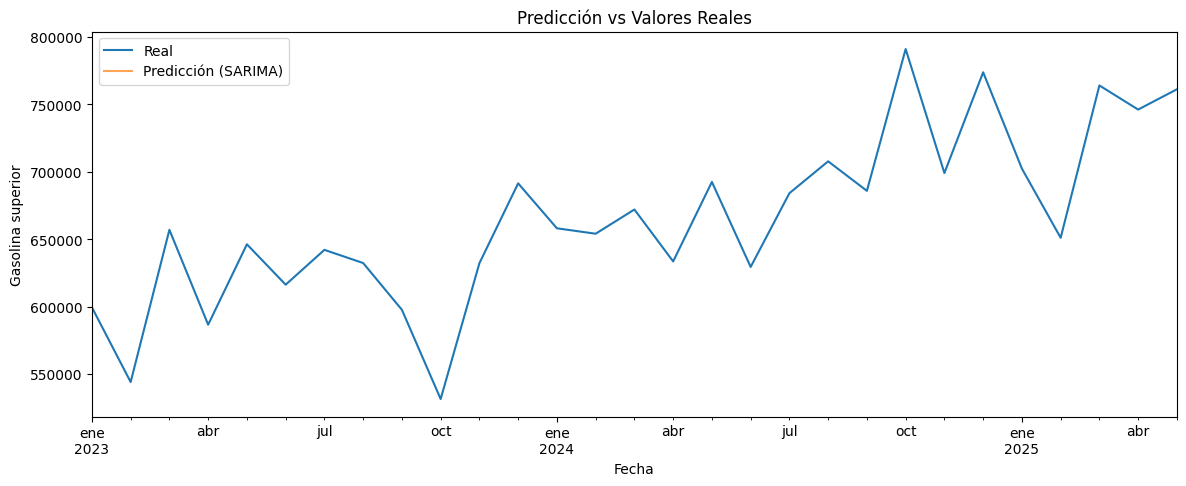

In [ ]:
# Graficar los datos reales
ax = test_data["Gasolina superior"].plot(label="Real", figsize=(14,5))

# Graficar la predicción convertida a valores reales
predicted_real.plot(ax=ax, label="Predicción (SARIMA)", alpha=0.7)

# Agregar leyenda y título
plt.title("Predicción vs Valores Reales")
plt.xlabel("Fecha")
plt.ylabel("Gasolina superior")
plt.legend()
plt.show()


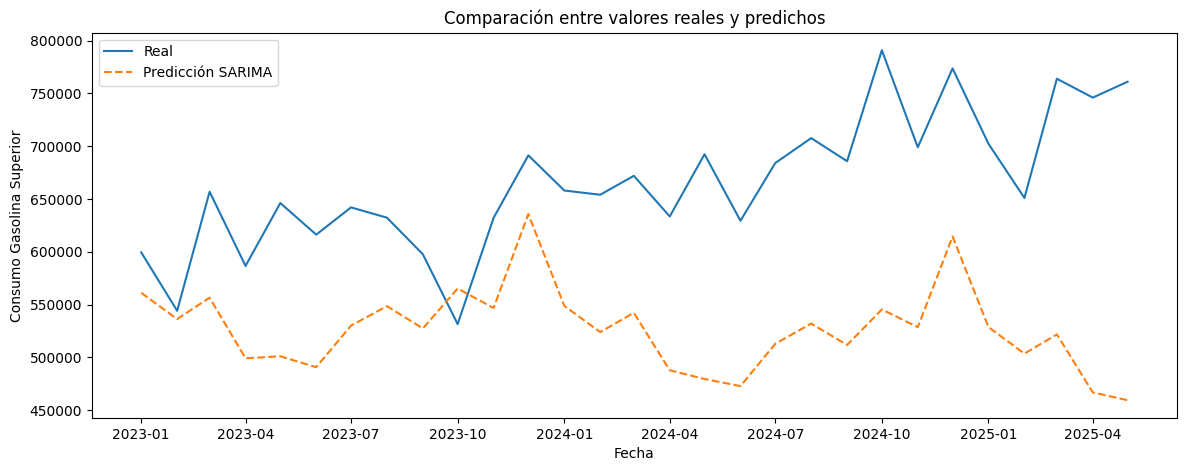

In [ ]:
xls = pd.read_excel("./data/preciosLimpio.xlsx", sheet_name=None)

resultados = {}

for nombre_hoja, df in xls.items():
    hoja_df = pd.read_excel("./data/preciosLimpio.xlsx", sheet_name=nombre_hoja, header=7, usecols="A,C,D,E,F,G,H")
    resultados[nombre_hoja] = hoja_df

In [3]:
for nombre_hoja in resultados:
    df = resultados[nombre_hoja]
    resultados[nombre_hoja] = df.iloc[1:].reset_index(drop=True)

In [4]:
df_final = pd.DataFrame()

for nombre_hoja, df in resultados.items():
    df["Año"] = nombre_hoja
    df_final = pd.concat([df_final, df], ignore_index=True)

In [5]:
df_final.drop(columns=["Bunker"], inplace=True)
df_final.set_index("FECHA", inplace=True)
df_final.sort_index(ascending=True, inplace=True)

In [6]:
df_final.index = pd.to_datetime(df_final.index)

# Filtrar test: todo el año 2025
test_gas = df_final[df_final.index.year == 2025]

# Filtrar train: todo antes de 2025
train_gas = df_final[df_final.index.year < 2025]


In [7]:
train_gas["Año"]

FECHA
2021-01-01    2021
2021-01-02    2021
2021-01-03    2021
2021-01-04    2021
2021-01-05    2021
              ... 
2024-12-27    2024
2024-12-28    2024
2024-12-29    2024
2024-12-30    2024
2024-12-31    2024
Name: Año, Length: 1461, dtype: object

In [8]:
# Asegurar que el índice es datetime
train_gas.index = pd.to_datetime(train_gas.index)

# Ver inicio y fin
print("Inicio:", train_gas.index.min())
print("Fin:", train_gas.index.max())

# Verificar frecuencia estimada
frecuencia = pd.infer_freq(train_gas.index)
print("Frecuencia estimada:", frecuencia)

# Si no tiene frecuencia definida, puedes asignarla si sabes que es diaria
train_gas = train_gas.asfreq('D')


Inicio: 2021-01-01 00:00:00
Fin: 2024-12-31 00:00:00
Frecuencia estimada: D


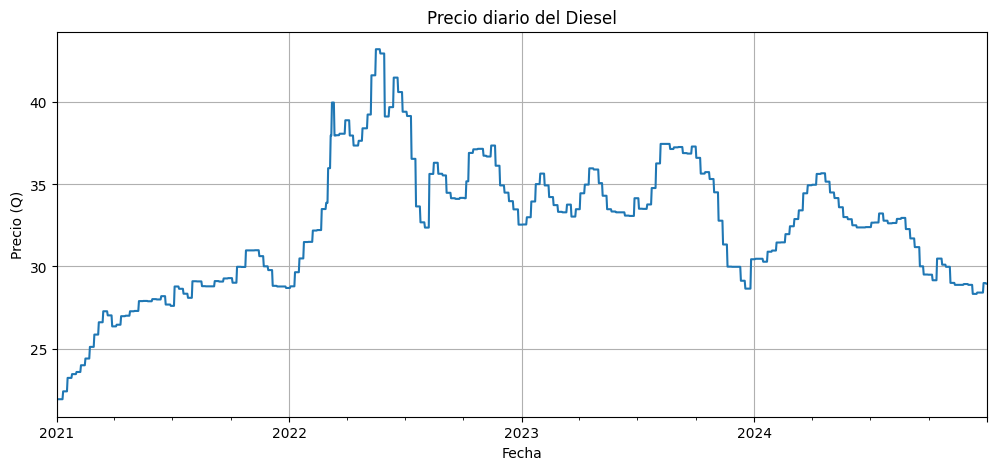

In [10]:
train_gas["Superior"].plot(figsize=(12, 5), title="Precio diario del Diesel")
plt.xlabel("Fecha")
plt.ylabel("Precio (Q)")
plt.grid(True)
plt.show()


A simple vista se pueden ver varias tendencias que ocurren a lo largo de los años. Desde el año 2021 a 2022 se presento una tendencia creciente donde los precios subieron de Q20 posteriormente se observa un periodo de alta volatibilidad, con altos crecimientos y caidas continuas. Posteriormente  de esta etapa, los precios empiezan a descender y estabilizarse. Se puede obsrevar como hay una alta variabilidad en los precios. Esto implica que no es estacionaria en varianza y tampoco en media.

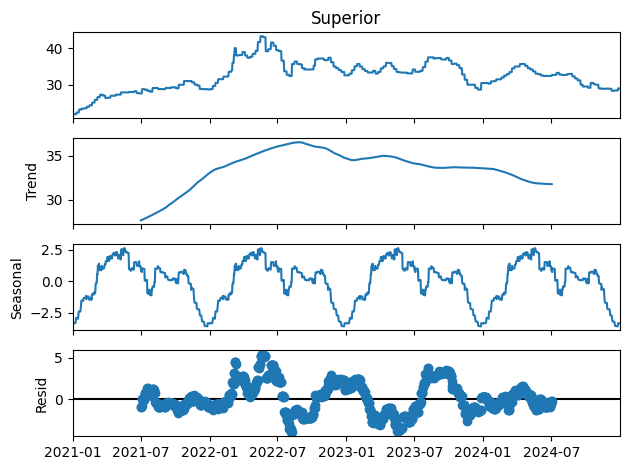

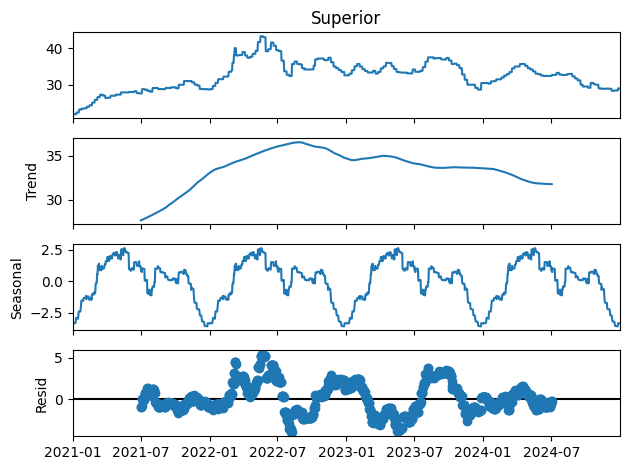

In [14]:
decomposition = seasonal_decompose(train_gas["Superior"], period=365)
decomposition.plot()
# plt.tight_layout()
# plt.show()


En la tendencia se muestra un crecimiento constante hasta 2022, alcanzando un punto maximo en julio. Seguido de esto se ecuentra una disminucion hasta 2024, esto indica que la seria no es estacionaria en meia, debido a que la media cambia mucho a lo largo del tiempo.En cuanto a lo estacional, se observa un patron anual que se repite, lo que se puede interpretar que existe la estacionalidad en la serie y el precio del siesel se ve afectado por factores externos.Con respecto a la varianza, los residuos muestran que no son constantes, hay periodos donde las desviaciones respecto a la tendencia son mucho mayores, mientras que en otros momentos se reduce notablemente. Esto sugiere que tampoco hay estacionariedad en varianza.

El grafico de descomposicion mostro que la serie no es estacionaria ni en media ni en varianza, requiere transformaciones antes de aplicar el modelo de prediccion



In [31]:
train_gas["Diesel"].isna().sum()

0

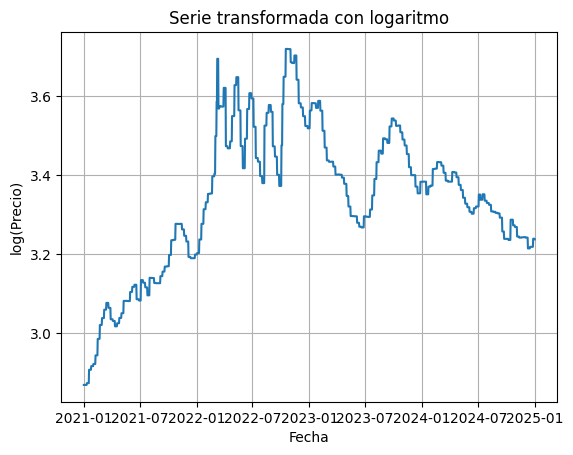

In [33]:
# Copiar la serie original
serie_diesel = train_gas["Diesel"].copy()

# Reemplazar ceros o negativos por el mínimo valor positivo válido
min_val = serie_diesel[serie_diesel > 0].min()
serie_diesel_segura = serie_diesel.apply(lambda x: x if x > 0 else min_val)

# Aplicar log
diesel_log = np.log(serie_diesel_segura)

plt.plot(diesel_log)
plt.title("Serie transformada con logaritmo")
plt.xlabel("Fecha")
plt.ylabel("log(Precio)")
plt.grid()
plt.show()


In [34]:
print('Resultados del Test de Dickey Fuller')
dfTest = adfuller(serie_diesel_segura, autolag='AIC')
salidaDf = pd.Series(dfTest[0:4], index=['Estadístico de prueba','p-value','# de retardos usados','# de observaciones usadas'])
for key,value in dfTest[4].items():
        salidaDf['Critical Value (%s)'%key] = value
print(salidaDf)

Resultados del Test de Dickey Fuller
Estadístico de prueba          -2.588594
p-value                         0.095378
# de retardos usados           24.000000
# de observaciones usadas    1436.000000
Critical Value (1%)            -3.434912
Critical Value (5%)            -2.863555
Critical Value (10%)           -2.567843
dtype: float64


El p-value es mayor a 0.05 por lo que no se puede rechazar la hipótesis nula de que existen raices unitarias. La serie no es estacionaria en media. Vamos a probar con una diferenciación

In [35]:
print('Resultados del Test de Dickey Fuller para una diferenciación de la serie')
ts_air_pas_diff = serie_diesel_segura.diff()
ts_air_pas_diff.dropna(inplace=True)
dfTest = adfuller(ts_air_pas_diff)
salidaDf = pd.Series(dfTest[0:4], index=['Estadístico de prueba','p-value','# de retardos usados','# de observaciones usadas'])
for key,value in dfTest[4].items():
        salidaDf['Critical Value (%s)'%key] = value
print(salidaDf)

Resultados del Test de Dickey Fuller para una diferenciación de la serie
Estadístico de prueba       -7.544537e+00
p-value                      3.310216e-11
# de retardos usados         2.300000e+01
# de observaciones usadas    1.436000e+03
Critical Value (1%)         -3.434912e+00
Critical Value (5%)         -2.863555e+00
Critical Value (10%)        -2.567843e+00
dtype: float64


El p-value es mayor a 0.05, por lo que sigue siendo estacionaria en media. Probemos otra diferenciación

In [36]:
ts_air_pas_diff = ts_air_pas_diff.diff()
ts_air_pas_diff.dropna(inplace=True)
dfTest = adfuller(ts_air_pas_diff)
salidaDf = pd.Series(dfTest[0:4], index=['Estadístico de prueba','p-value','# de retardos usados','# de observaciones usadas'])
for key,value in dfTest[4].items():
        salidaDf['Critical Value (%s)'%key] = value
print(salidaDf)

Estadístico de prueba       -1.343862e+01
p-value                      3.884933e-25
# de retardos usados         2.200000e+01
# de observaciones usadas    1.436000e+03
Critical Value (1%)         -3.434912e+00
Critical Value (5%)         -2.863555e+00
Critical Value (10%)        -2.567843e+00
dtype: float64


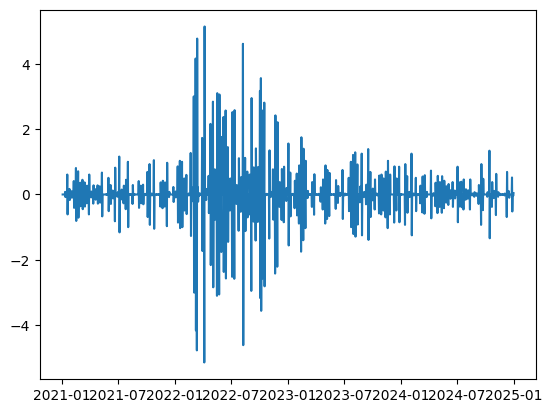

In [37]:
plt.plot(ts_air_pas_diff)


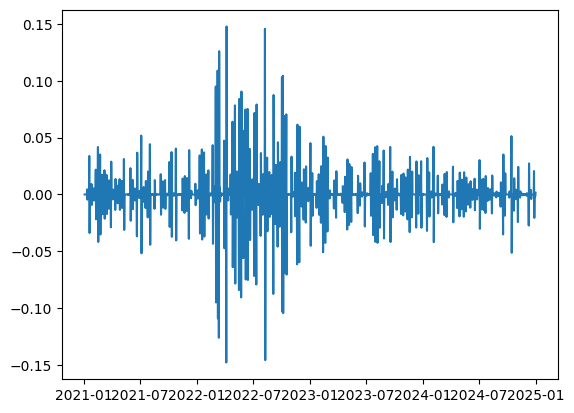

In [38]:
plt.plot(diesel_log.diff().diff())


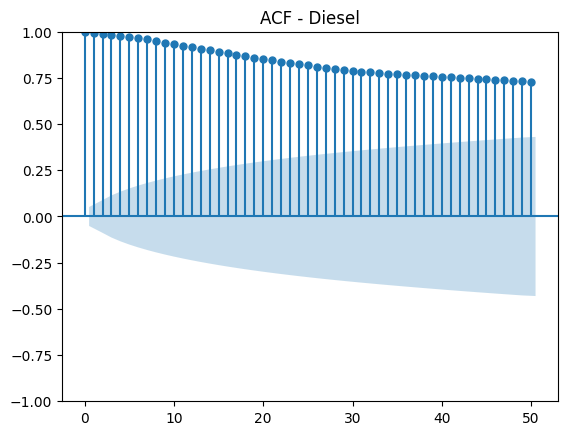

In [26]:
from statsmodels.graphics.tsaplots import plot_acf
plot_acf(train_gas["Diesel"].dropna(), lags=50)
plt.title("ACF - Diesel")
plt.show()


In [25]:
adf_result = adfuller(train_gas["Diesel"].dropna())
print(f"ADF Statistic: {adf_result[0]}")
print(f"p-value: {adf_result[1]}")


ADF Statistic: -2.5885944071697193
p-value: 0.09537755906053796
